In [1]:
from functions import *
from random import sample
from htmldate import find_date
from concurrent.futures import ThreadPoolExecutor
from bs4 import BeautifulSoup
import json
from langid.langid import LanguageIdentifier, model
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib
from purl import URL
import re

In [2]:
base_path = "/media/ruben/Data Drive/react-data/protest/carlo-batch-selection"


# Get Publication Dates

dates_ref = dict()

for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
    photo_folder = os.path.join(base_path, photo)
    with open(os.path.join(photo_folder,"dates.txt"),'r') as f:
        x = f.readlines()
    dates_ref.update({d.split('|')[0]:d.split('|')[-1].replace('\n','') for d in x if d.split('|')[-1].replace('\n','') != "na" and "ERROR" not in d.split('|')[-1].replace('\n','')})

# Get URL-ID from entity files
ids_ = dict()

for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
    photo_folder = os.path.join(base_path, photo)
    
    folders = [fol for fol in os.listdir(photo_folder) if os.path.isdir(os.path.join(photo_folder,fol)) and "source" not in fol and "context" not in fol]
    
    for f in folders:
        fn = os.path.join(photo_folder, f, "txt","parsed_text.json")

        with open(fn) as fp:
            file = json.load(fp)
        
        for id_ in file.keys():
            
            identif = id_.split("html_")[0].split('html/')[-1][:-1]
            url = id_.split("html_")[1]
            ids_.update({identif:url})

In [3]:
tlds = []

for id_,date in dates_ref.items():
    year = date[0:4]
    tld = URL.from_string(id_).domain()
    tlds.append([tld,year,1])

In [11]:
pd.DataFrame(Counter([t[0] for t in tlds]).most_common(50),columns=['tld','n']).to_csv('/media/ruben/FEF44259F44213F5/Users/Ruben/Documents/GitHub/ReACT_GCV/data/images_tables_article_2/top-level-domains.csv',index=False)

In [5]:
pd.DataFrame(Counter([t[0] for t in tlds]).most_common(150),columns=['tld','n'])

,tld,n
0,twitter.com,83
1,www.youtube.com,43
2,www.pinterest.com,28
3,www.facebook.com,28
4,www.militant-blog.org,24
...,...,...
145,luxwatch.ua,4
146,www.chrono24.tw,4
147,www.chrono24.de,4
148,www.petitegeneve.com,4


In [83]:
# Diachronic Relative Frequency Blogs

dfu = pd.DataFrame(tlds,columns=['tld','y','c']).groupby(['tld','y']).sum().reset_index()
dfu['cat'] = ""

for c,i in enumerate(dfu['tld']):
        
    if any(n in i for n in ['facebook','pinterest','instagram','twitter','myspace','foursquare','hyves','youtube','dailymotion']):
        dfu['cat'][c] = "social"
        
    elif any(n in i for n in ['blog','wordpress']):
        dfu['cat'][c] = "blog"
        
    elif any(n in i for n in "news liberation iltabloid businessinsider aftonbladet aftenposten bbc guardian nytimes gazetta corriere repubblica isole24ore ilrestodelcarlino ilmessaggero nazione avvenire ilgiorno ilgiornale ilmattino italiaoggi ilfattoquotidiano libero laverita liberomilanonegozi iltempo".split(' ')):
        dfu['cat'][c] = "news"
    else:
        dfu['cat'][c] = "other"

/home/ruben/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ruben/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/ruben/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ruben/anaconda3/lib/p

In [84]:
dfr = []

for i in list(set(dfu['y'])):
    total = len(dfu[dfu['y'] == i])
    blog = len(dfu[(dfu['y'] == i) & (dfu['cat'] == "blog")]) / total
    social = len(dfu[(dfu['y'] == i) & (dfu['cat'] == "social")]) / total
    news = len(dfu[(dfu['y'] == i) & (dfu['cat'] == "news")]) / total
    other = len(dfu[(dfu['y'] == i) & (dfu['cat'] == "other")]) / total
    dfr.append([i,total,blog,social,news,other])

In [85]:
dfr = pd.DataFrame(dfr,columns = ['year','total','blog','social','news','other']).sort_values('year',ascending=True).reset_index(drop=True)

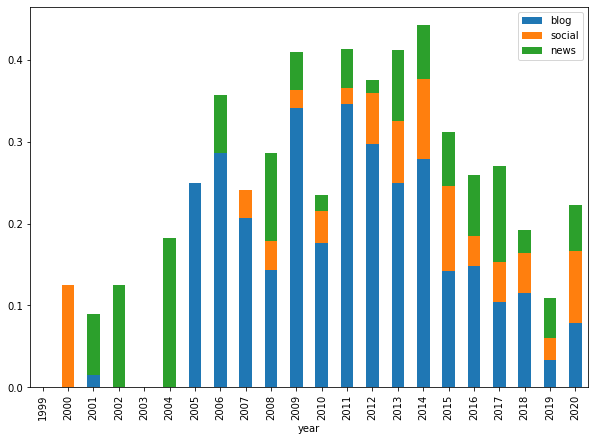

In [89]:
dfr.plot.bar(x='year',y=['blog','social','news'],stacked=True,figsize=(10,7))

In [90]:
dfu[dfu['y'] == "2003"]

,tld,y,c,cat
60,athens.indymedia.org,2003,2,other
285,genius.com,2003,3,other
495,open.spotify.com,2003,3,other
733,www.amazon.com,2003,1,other
853,www.declarepeace.org.uk,2003,1,other
1083,www.lestintorecheamleto.net,2003,1,other
1166,www.nrk.no,2003,1,other


In [88]:
[t for t in tlds if any(n in t[0] for n in ['500px','imgur','flickr','tumblr'])]

[['guneslipazartesiler-blog.tumblr.com', '2011', 1],
 ['www.tumblr.com', '2017', 1],
 ['www.flickr.com', '2020', 1],
 ['www.tumblr.com', '2015', 1],
 ['www.tumblr.com', '2015', 1],
 ['routine-routine.tumblr.com', '2019', 1],
 ['sp1thas.tumblr.com', '2018', 1],
 ['nuovistilidinsonnia.tumblr.com', '2017', 1],
 ['sandimgetriebe.tumblr.com', '2017', 1],
 ['www.flickriver.com', '2007', 1],
 ['www.flickriver.com', '2010', 1],
 ['www.tumblr.com', '2019', 1],
 ['www.flickr.com', '2020', 1],
 ['www.flickr.com', '2020', 1],
 ['www.flickriver.com', '2007', 1],
 ['www.flickriver.com', '2007', 1],
 ['hellyeahanarchistposters.tumblr.com', '2019', 1],
 ['www.flickriver.com', '2007', 1],
 ['www.flickr.com', '2020', 1],
 ['italian-malmostoso.tumblr.com', '2020', 1],
 ['imgur.com', '2017', 1],
 ['supercazzolaprematurata.tumblr.com', '2020', 1]]